In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from skimage import color

#img = color.rgb2gray(io.imread('image.png'))

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap='gray')

    plt.show()

Funcion para convertir las imagenes a escala de grises:


```
color.rgb2gray( <image> )
```



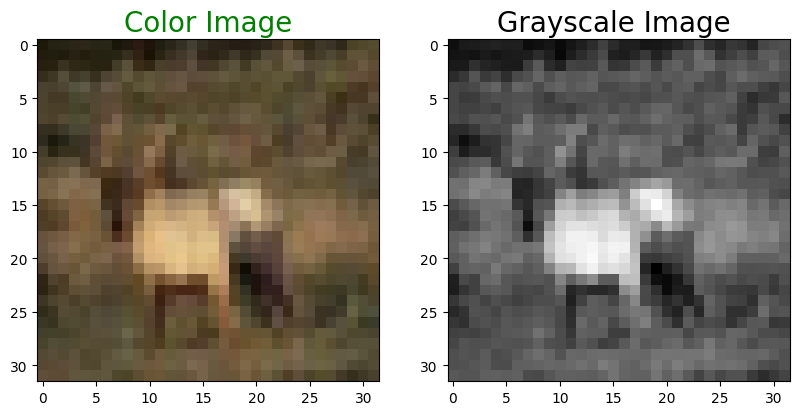

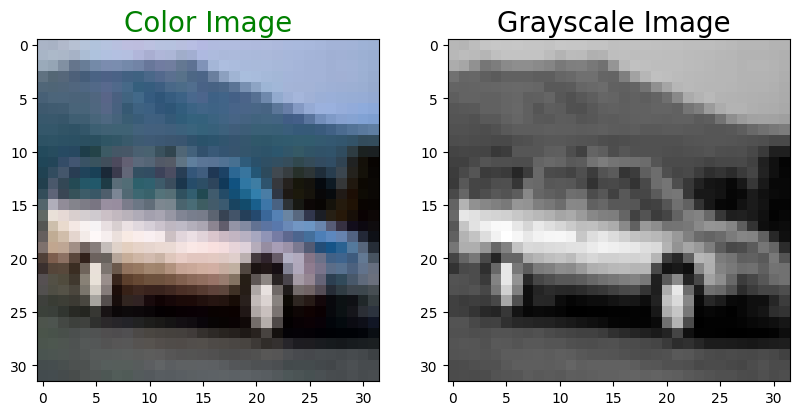

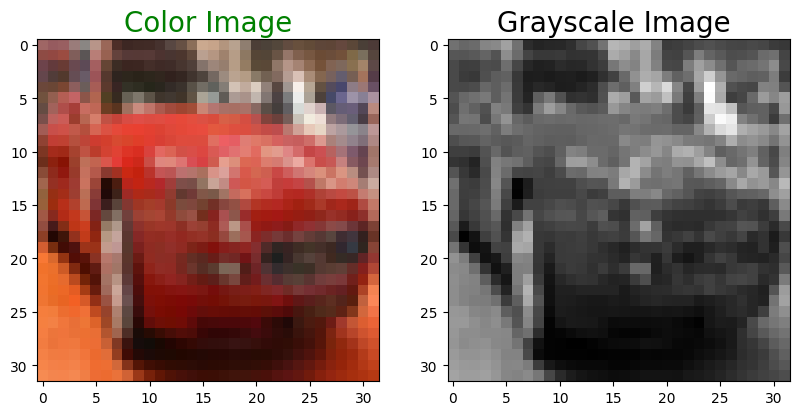

In [4]:
for i in range(3,6):
  plot_images(x_train[i],color.rgb2gray(x_train[i]))

## Enunciado de la práctica 1

Para esta práctica hemos creido necesario que se debe poner en práctica todo lo impartido hasta la fecha, es decir, no solo las arquitecturas impartidad sino tambien las diferentes tipologías de redes mostrada hasta el momento.

Para ello, mediante el dataset anterior queremos implementar un modelo capaz de frente a una entrada de imagenes en blanco y negro, sea capaz de colorearlas. De esta manera se establecen los siguiente puntos:


1.   Implementar la arquitectura mediante redes MLP
2.   Implementar la arquitectura mediante redes Convolucionales
3.   (Opcional) Probar diferentes arquitecturas CNN que puedan mejorar lo resultados.



El conjunto de datos CIFAR-10 consta de 60000 imágenes en color de 32x32 en 10 clases, con 6000 imágenes por clase. Hay 50.000 imágenes de entrenamiento y 10.000 imágenes de prueba.

Las clases son: (hago una captura que meto en el github para que veas de donde las he sacado)

0 airplane

1 automobile

2 bird

3 cat

4 deer

5 dog

6 frog

7 horse

8 ship

9 truck

In [5]:
# conversión de imágenes en color a escala de grises
X_train=color.rgb2gray(x_train)
X_test=color.rgb2gray(x_test)

In [6]:
# aplanamos el conjunto de datos. Pasaremos de un arreglo multidimensional a un arreglo unidimensional que es necesario para problemas de clasificacion
y_train = y_train.flatten()
y_test = y_test.flatten()

In [7]:
# convertimos las etiquetas en codificacion 'one_hot'. Usaremos la funcion función tf.one_hot de TensorFlow que se utiliza para convertir las etiquetas enteras
#en una representación binaria donde un valor entero se representa como un vector con un solo 1 en la posición correspondiente al valor original.
#En este caso, depth=10 indica que el rango de valores enteros es de 0 a 9 (un problema de clasificación con 10 clases).
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

In [8]:
X_train

array([[[0.24092   , 0.17760941, 0.18848824, ..., 0.53252784,
         0.50619294, 0.50033686],
        [0.07509804, 0.        , 0.03744392, ..., 0.36493412,
         0.34615961, 0.36186078],
        [0.09410275, 0.03297176, 0.11884353, ..., 0.34813176,
         0.34979843, 0.30750941],
        ...,
        [0.6774102 , 0.60635333, 0.62403529, ..., 0.52625569,
         0.13561608, 0.14520824],
        [0.56710667, 0.50111725, 0.56747294, ..., 0.59512392,
         0.26438706, 0.22747098],
        [0.58428902, 0.52848627, 0.5721451 , ..., 0.73579451,
         0.48063176, 0.38096275]],

       [[0.67777843, 0.52780549, 0.40613176, ..., 0.3624298 ,
         0.34506902, 0.3128702 ],
        [0.61332902, 0.59361608, 0.48821686, ..., 0.37979765,
         0.30613608, 0.2812149 ],
        [0.59788784, 0.56756392, 0.45013216, ..., 0.31397922,
         0.26860196, 0.26496314],
        ...,
        [0.66128588, 0.60728471, 0.62527843, ..., 0.14056549,
         0.21564078, 0.33608549],
        [0.6

In [9]:
X_train.shape


(50000, 32, 32)

In [10]:
y_train

<tf.Tensor: shape=(50000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)>

In [11]:
y_train.shape

TensorShape([50000, 10])

### 1. Implementar la arquitectura mediante redes MLP

Las redes MLP son una clase fundamental de redes neuronales artificiales que se utilizan ampliamente en el aprendizaje automático y el procesamiento de datos. Estas redes están compuestas por múltiples capas de neuronas interconectadas, lo que les permite modelar relaciones complejas en datos, como patrones en imágenes, secuencias de tiempo, texto, y más.

**Componentes clave de una red MLP:**

1.Neuronas (o nodos): En cada capa de la red, se encuentran unidades llamadas neuronas o nodos. Cada neurona toma entradas, realiza una operación matemática y produce una salida.

2.Capas de la red: Las redes MLP generalmente constan de tres tipos de capas:

-Capa de entrada (Input Layer): Esta capa recibe los datos de entrada, como características de un conjunto de datos. Cada neurona en esta capa representa una característica de entrada.

-Capas ocultas (Hidden Layers): Estas capas intermedias entre la capa de entrada y la capa de salida realizan cálculos y transformaciones no lineales en los datos. La inclusión de múltiples capas ocultas permite a la red aprender representaciones jerárquicas y abstracciones de los datos.

-Capa de salida (Output Layer): La capa de salida produce los resultados finales de la red. Dependiendo de la tarea, puede haber una o varias neuronas en esta capa. Por ejemplo, en una tarea de clasificación, cada neurona en la capa de salida puede representar una clase diferente.

3.Conexiones ponderadas: Cada conexión entre las neuronas está asociada con un peso que determina la influencia de una neurona en la siguiente. Los pesos se ajustan durante el entrenamiento de la red para que la red pueda aprender a realizar tareas específicas.

**Funcionamiento de una Red MLP:**

El proceso de entrenamiento de una red MLP implica los siguientes pasos:

1.Propagación hacia adelante (Forward Propagation): Durante esta fase, los datos de entrada se propagan a través de la red, capa por capa, utilizando los pesos asociados con las conexiones ponderadas. Cada neurona realiza una suma ponderada de sus entradas y aplica una función de activación no lineal, como la función sigmoide o la función ReLU, a la suma ponderada para calcular su salida.

2.Cálculo de la pérdida (Loss Calculation): Luego de la propagación hacia adelante, se calcula la diferencia entre las salidas de la red y las salidas deseadas (etiquetas reales), lo que se conoce como función de pérdida. El objetivo del entrenamiento es minimizar esta pérdida.

3.Propagación hacia atrás (Backpropagation): Para ajustar los pesos y minimizar la pérdida, se utiliza el algoritmo de retropropagación. Este algoritmo calcula las derivadas de la función de pérdida con respecto a los pesos en la red y ajusta los pesos mediante un algoritmo de optimización, como el descenso de gradiente.

In [12]:
# definimos el modelo base
def MLP_model():
  #creamos el modelo
  model = keras.Sequential()
  model.add(Flatten(input_shape=(32,32,1)))
  model.add(Dense(2048, activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(10, activation='softmax')) #funcion de activación en la capa de salida softmax por ser un problema multiclase, si fuese binario sigmoide
  #compilamos el modelo
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model


In [13]:
# construimos el modelo
model = MLP_model()

In [14]:
# entrenamos el modelo
history = model.fit(X_train, y_train,batch_size=40, epochs=30, validation_split=0.2, validation_data=(X_test, y_test))


Epoch 1/30
1250/1250 [==============================] - 14s 6ms/step - loss: 0.3029 - accuracy: 0.2386 - val_loss: 0.2881 - val_accuracy: 0.2909
Epoch 2/30
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2812 - accuracy: 0.3102 - val_loss: 0.2825 - val_accuracy: 0.3082
Epoch 3/30
1250/1250 [==============================] - 7s 5ms/step - loss: 0.2724 - accuracy: 0.3409 - val_loss: 0.2686 - val_accuracy: 0.3595
Epoch 4/30
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2661 - accuracy: 0.3575 - val_loss: 0.2618 - val_accuracy: 0.3753
Epoch 5/30
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2615 - accuracy: 0.3749 - val_loss: 0.2617 - val_accuracy: 0.3723
Epoch 6/30
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2574 - accuracy: 0.3883 - val_loss: 0.2580 - val_accuracy: 0.3829
Epoch 7/30
1250/1250 [==============================] - 7s 5ms/step - loss: 0.2526 - accuracy: 0.4011 - val_loss: 0.2556 - val_accuracy

Vemos las gráficas del entrenamiento

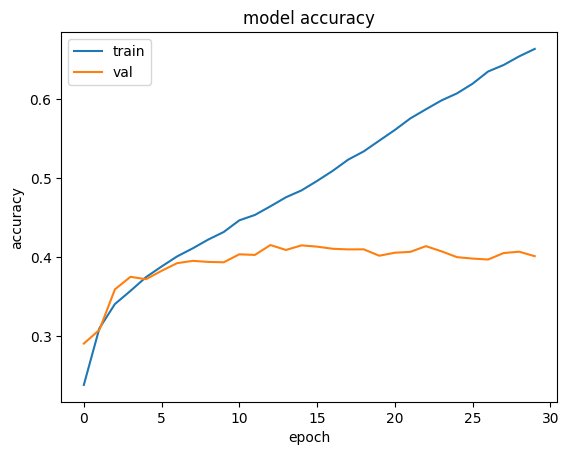

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

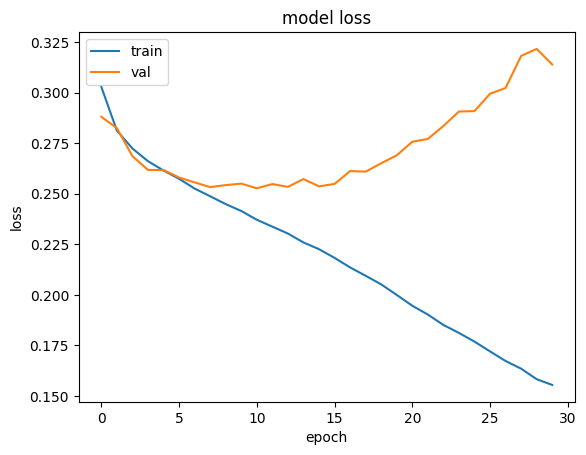

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [17]:
# evaluación final del modelo
scores = model.evaluate(X_test, y_test)
print("accuracy: %.2f%%" % (scores[1]*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.3140 - accuracy: 0.4014
accuracy: 40.14%


Vemos que el porcentaje es bastante bajo pero teniendo en cuenta que lo estamos haciendo con una arquitectura mediante una red MLP para este ejercicio no esta nada mal.

Ahora vamos a hacerlo con CNN y veremos como mejora la preddicción.

### 2.Implementar la arquitectura mediante redes Convolucionales

La implementación de la arquitectura mediante redes convolucionales (CNN, por sus siglas en inglés) es un enfoque fundamental en el campo de la visión por computadora y el procesamiento de imágenes. Las redes convolucionales son un tipo especializado de red neuronal diseñadas para capturar patrones visuales y estructuras jerárquicas en datos de imágenes. Esta arquitectura se ha convertido en un pilar esencial en numerosas aplicaciones, como reconocimiento de objetos, segmentación de imágenes, clasificación de imágenes, detección de rostros y mucho más.

Las redes convolucionales se inspiran en la forma en que el cerebro humano procesa información visual, extrayendo características locales y luego combinándolas para reconocer patrones más complejos. Esto se logra mediante capas de convolución que aplican filtros a la imagen de entrada para detectar características como bordes, texturas y formas. A medida que avanzamos a través de las capas, las características se combinan y refinan, permitiendo que la red aprenda características cada vez más abstractas y representaciones de alto nivel de las imágenes.

La arquitectura de una CNN generalmente consiste en una alternancia de capas de convolución, capas de agrupación (pooling) para reducir la resolución espacial y capas completamente conectadas para la clasificación final. Además, técnicas como la regularización, la normalización y las funciones de activación (como ReLU) desempeñan un papel importante en la mejora del rendimiento y la generalización de la red.

La implementación exitosa de una CNN implica la selección adecuada de arquitectura, la recopilación de datos de entrenamiento significativos y el ajuste de hiperparámetros para lograr un rendimiento óptimo en una tarea específica. A medida que avanza el campo, también han surgido numerosas arquitecturas preentrenadas, como VGG, ResNet, Inception y MobileNet, que se pueden utilizar como base y ajustar para tareas específicas.

In [18]:
def CNN_model():
  # creamos el modelo
  model = Sequential()
  #definimos la primera capa convolucional. Conv2D(32, (5, 5)) crea una capa convolucional con 32 filtros (o neuronas) de 5x5 píxeles. Ponemos padding='same' para asegurarnos
  #de que la salida de la capa tenga el mismo tamaño que la entrada. Después definimos strides=1 que es el tamaño del paso que se toma al aplicar el filtro a través de la imagen,
  #esto quiere decir que  la submatriz se ira moviendo una vez cada posicion. Utilizamos  la función de activación ReLU (Rectified Linear Unit) para introducir la
  #no linealidad en la capa. Por último establecemos el input_shape=(32, 32, 1), que especifica la forma de entrada de la imagen, que es de 32x32 píxeles en escala de grises (1 canal).
  model.add(Conv2D(32, (5, 5), padding='same',strides=1, activation='relu', input_shape=(32, 32, 1)))
  #Aplicamos un max-pooling con un filtro de 2x2, lo que reduce la resolución espacial de la imagen a la mitad y ayuda a reducir el número de parámetros en la red.
  model.add(MaxPooling2D((2, 2)))
  #Añadimos uan capa  dropout que apaga aleatoriamente el 20% de las neuronas durante el entrenamiento para prevenir el sobreajuste.
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (5, 5), padding='same',strides=1, activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (5, 5), padding='same',strides=1, activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(256, (5, 5), padding='same',strides=1, activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  #Añadimos la capa flatten que aplana la matriz y convierte la salida de las capas convolucionales en un vector unidimensional para alimentar una capa completamente conectada.
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  #compilamos el modelo
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

Hemos comentado que hace cada parte del código, ya que el resto de capas convolucionales que se añaden siguen la misma estructura que la comentada, exceptuando obviamente input_shape=(32, 32, 1) que es la capa de entrada.
Lo único que varia es las capas convolucionales es el número de filtros que van aumentando en un x2 en cada capa.

In [19]:
#construimos el modelo
model2=CNN_model()

In [20]:
#vemos un resumen del modelo mostrando las capas
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)         

In [21]:
#entrenamos el modelo
history = model2.fit(X_train, y_train,batch_size=40, epochs=30, validation_split=0.2, validation_data=(X_test, y_test))

Epoch 1/30
1250/1250 [==============================] - 17s 7ms/step - loss: 0.2601 - accuracy: 0.3625 - val_loss: 0.2066 - val_accuracy: 0.5309
Epoch 2/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1934 - accuracy: 0.5656 - val_loss: 0.1678 - val_accuracy: 0.6341
Epoch 3/30
1250/1250 [==============================] - 8s 6ms/step - loss: 0.1647 - accuracy: 0.6442 - val_loss: 0.1518 - val_accuracy: 0.6740
Epoch 4/30
1250/1250 [==============================] - 8s 7ms/step - loss: 0.1501 - accuracy: 0.6777 - val_loss: 0.1396 - val_accuracy: 0.7012
Epoch 5/30
1250/1250 [==============================] - 8s 7ms/step - loss: 0.1385 - accuracy: 0.7038 - val_loss: 0.1401 - val_accuracy: 0.7025
Epoch 6/30
1250/1250 [==============================] - 8s 7ms/step - loss: 0.1300 - accuracy: 0.7243 - val_loss: 0.1347 - val_accuracy: 0.7153
Epoch 7/30
1250/1250 [==============================] - 8s 7ms/step - loss: 0.1227 - accuracy: 0.7406 - val_loss: 0.1297 - val_accuracy

Vemos las gráficas de entrenamiento

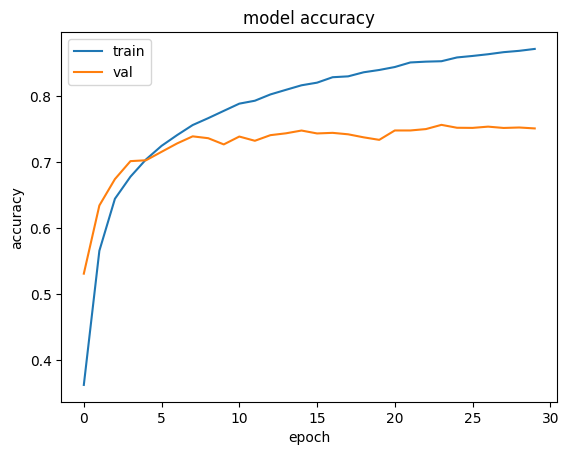

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

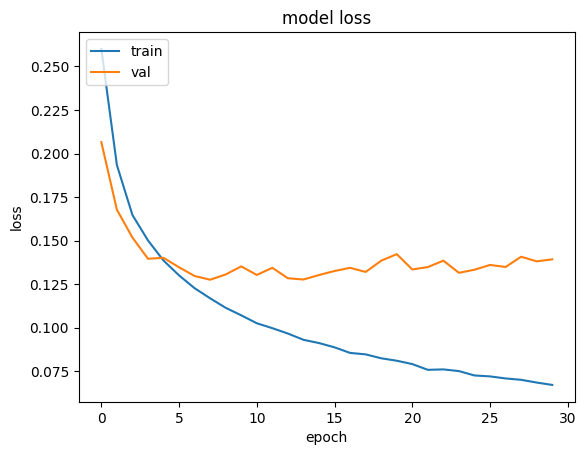

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
# evaluación final del modelo
scores = model2.evaluate(X_test, y_test)
print("accuracy: %.2f%%" % (scores[1]*100))

313/313 [==============================] - 2s 4ms/step - loss: 0.1392 - accuracy: 0.7507
accuracy: 75.07%


Como habiamos dicho anteriormente la precision mejora bastante con la arquitectura mediante redes convolucionales. Ya hemos obtenido un porcentaje bastante elevado ya que tenemos 10 posibles diferentes salidas.

### 3.(Opcional) Probar diferentes arquitecturas CNN que puedan mejorar lo resultados.

Vamos a probar la rer preentrenada VGG16 con los pesos de imagenter que la hemos visto en la asigatura de optimizacion en redes, veremos que con VGG16 el entrenamiento mejorara aun mas obteniendo como consecuencia una mejro prediiccion.

VGG16 es un modelo de red neuronal convolucional (CNN) ampliamente utilizado en el campo del aprendizaje profundo y la visión por computadora. Fue desarrollado por el grupo Visual Geometry Group (VGG) en la Universidad de Oxford y es una de las arquitecturas de CNN más influyentes.

La designación "VGG16" se refiere a la arquitectura específica del modelo, que consta de 16 capas convolucionales y de pooling, seguidas de tres capas completamente conectadas. Fue diseñado originalmente para la tarea de clasificación de imágenes en el concurso ImageNet Large Scale Visual Recognition Challenge.

VGG16 se caracteriza por su simplicidad y uniformidad en la arquitectura, con capas convolucionales de 3x3 y pooling de 2x2 en todo el modelo. Esto hace que sea fácil de entender y entrenar, lo que lo convierte en una opción popular para la transferencia de aprendizaje, donde se toma una red preentrenada en un gran conjunto de datos y se ajusta para tareas específicas.

VGG16 ha sido utilizado como punto de partida en muchas aplicaciones de visión por computadora y se ha demostrado efectivo en una amplia variedad de tareas, como clasificación de objetos, detección de objetos, segmentación semántica y más. Sin embargo, debido a su profundidad y cantidad de parámetros, VGG16 puede ser computacionalmente costoso de entrenar y usar en comparación con arquitecturas más recientes y eficientes, como las redes neuronales profundas (deep networks).

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#vemos un rsuemne de VGG16 mostrando sus capas
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
conv_base.trainable= False #para que los pesos de imagente no los sobreescriba esto es importante

In [ ]:
def VGG16_model():
  #creamos el modelo
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  #compilamos el modelo
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
#construimos el modelo
model3=VGG16_model()

In [ ]:
#mostramos resumen del modelo mostrando sus capas
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
#entranamos el modelo
history = model3.fit(X_train, y_train,batch_size=40, epochs=30, validation_split=0.2, validation_data=(X_test, y_test))

Vemos que no se puede hacer el entranemiento ya que VGG16 es una arquitectura que implica tres canales y en este ejericio al ser las imaganes en blanco y negro solo tenemos 1.